In [1]:
%pip install torch torchvision torchaudio transformers sentencepiece

Note: you may need to restart the kernel to use updated packages.


In [34]:
import torch
import numpy as np
import pandas as pd
import os
import torch
import matplotlib.pyplot as plt

from transformers import CamembertTokenizer, CamembertModel
from tqdm import tqdm
from transformers import CamembertTokenizer, CamembertModel
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,  ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_predict


In [13]:
####################### Dataframe import ######################

from create_dataframe import prepare_legislatives_dataset_without_bi_categories

csv_p = "/home/onyxia/work/NLP_rendus/.ipynb_checkpoints/data/legislatives_1981.csv"
txt_p = "/home/onyxia/work/NLP_rendus/.ipynb_checkpoints/data/legislatives_1981"

df_final_without_bi_categories = prepare_legislatives_dataset_without_bi_categories(csv_p, txt_p)

len(df_final_without_bi_categories)

1473

# 1. Embedding

We will generate numerical embeddings for a collection of texts using CamemBERT. Each text is converted into a 768-dimensional vector (the [CLS] token representation) which can then be used as input features (X) for machine learning models and taking into account the context and the semantic signification of worlds.
Batch processing and token truncation are applied to handle long texts efficiently and manage memory usage, with optional GPU acceleration.

In [17]:
#################### Embeddings (Purpose: Transform raw text into numerical vectors for ML tasks) #####################

#  Initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Use GPU if available
tokenizer = CamembertTokenizer.from_pretrained("camembert-base") # Tokenizer for CamemBERT
model = CamembertModel.from_pretrained("camembert-base").to(device) # Load model to device

def get_embeddings(text_list, batch_size=16):
    """
    DBT: Generate embeddings for a list of texts using CamemBERT.
    - Input: list of strings
    - Output: tensor of shape (num_texts, 768)
    """
    model.eval()  # Set model to evaluation mode
    all_embeddings = []
    
    # Process texts in batches to avoid memory overload
    for i in tqdm(range(0, len(text_list), batch_size)):
        batch_texts = text_list[i:i+batch_size]
        
        # Tokenize and encode, truncating long texts at 512 tokens
        inputs = tokenizer(batch_texts, padding=True, truncation=True, 
                           max_length=512, return_tensors="pt").to(device)
        
        with torch.no_grad(): # Disable gradient computation
            outputs = model(**inputs)
            # Take the [CLS] token embedding (first token) as text representation
            embeddings = outputs.last_hidden_state[:, 0, :].cpu()
            all_embeddings.append(embeddings)

    # Concatenate all batch embeddings into a single tensor        
    return torch.cat(all_embeddings, dim=0)

# Apply to dataframe
textes_1981 = df_final_without_bi_categories['text_content'].astype(str).tolist() # Extract text column as list

# Generate embeddings
features = get_embeddings(textes_1981)

# Results
print(f"Matrice de caractéristiques prête : {features.shape}")


Loading weights: 100%|██████████| 199/199 [00:00<00:00, 737.70it/s, Materializing param=pooler.dense.weight]                               
CamembertModel LOAD REPORT from: camembert-base
Key                       | Status     |  | 
--------------------------+------------+--+-
lm_head.dense.weight      | UNEXPECTED |  | 
lm_head.dense.bias        | UNEXPECTED |  | 
lm_head.bias              | UNEXPECTED |  | 
lm_head.layer_norm.bias   | UNEXPECTED |  | 
lm_head.layer_norm.weight | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
100%|██████████| 93/93 [03:27<00:00,  2.23s/it]

Matrice de caractéristiques prête : torch.Size([1473, 768])


# 2. Classification algorithms

We will test two algorithms using the embedding: random forest and SVM.

As we have some categories with a small number of manifestos, we will use stratified cross-validation and hyperparameter tuning.
Since the categories are imbalanced, we will use `class_weight='balanced'` to give more importance to minority classes and  maximize F1 score.



## 2.1 Random Forest

In [ ]:
X = features.numpy() if hasattr(features, 'numpy') else features  # features = CamemBERT embeddings
y = df_final_without_bi_categories['titulaire-soutien'].values  # labels

Fitting 5 folds for each of 12 candidates, totalling 60 fits
✅ Best RF hyperparameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}, F1 (CV): 0.7772

--- RANDOM FOREST CLASSIFICATION REPORT ---
                                    precision    recall  f1-score   support

                    Front national       1.00      0.91      0.95        44
  Ligue communiste révolutionnaire       1.00      1.00      1.00        32
                    Lutte ouvrière       1.00      1.00      1.00       159
  Mouvement des radicaux de gauche       1.00      0.02      0.04        46
         Parti communiste français       0.88      0.92      0.90       463
                  Parti socialiste       0.65      0.91      0.76       407
           Parti socialiste unifié       0.95      0.91      0.93       148
  Rassemblement pour la République       0.67      0.28      0.39       104
Union pour la démocratie française       0.80      0.06      0.11        70

                         

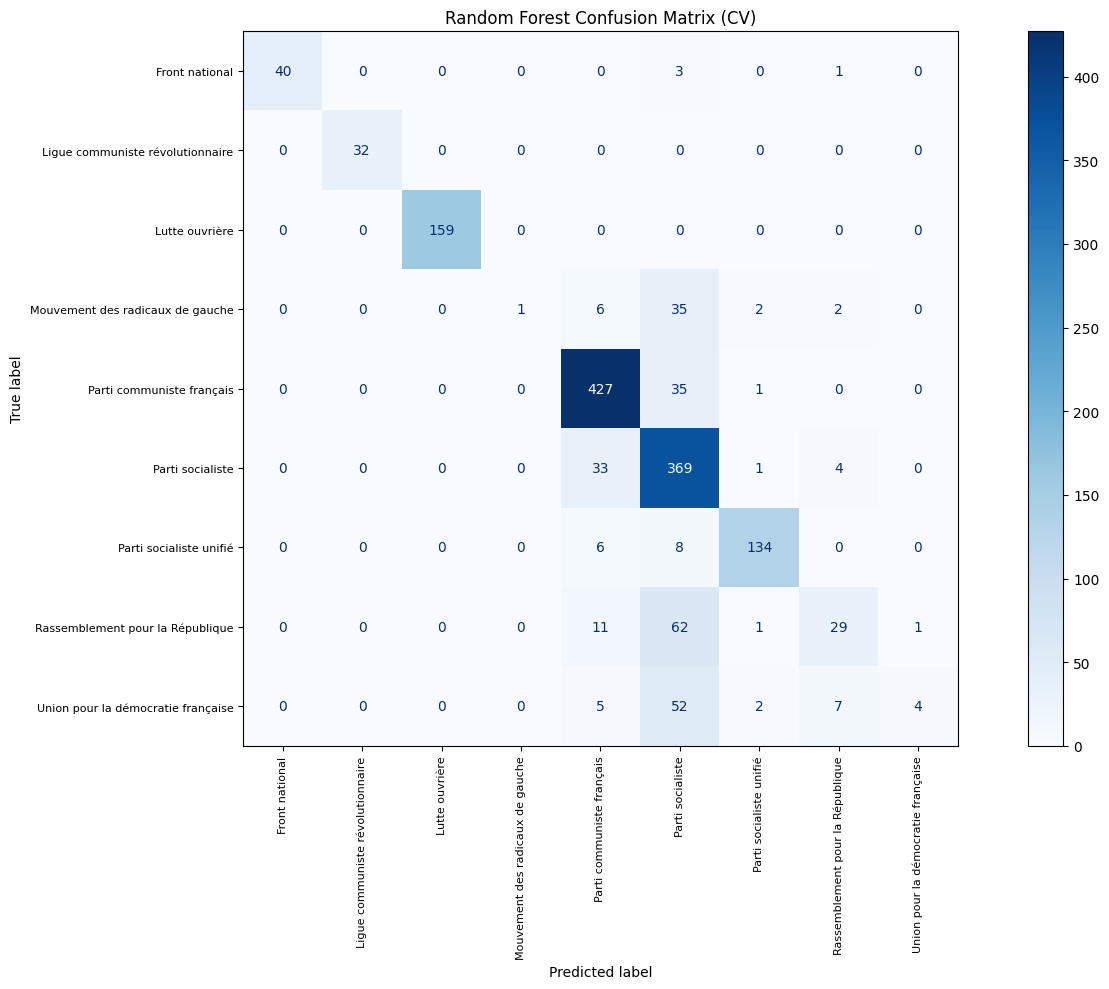

In [35]:
# ##############Train and evaluate a Random Forest classifier on CamemBERT embeddings ######################

#  Cross-validation strategy
cv_folds = 5
cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)  # preserve class proportions

# Random Forest hyperparameter grid
param_grid_rf_fine = {
    'n_estimators': [500, 750, 1000],       # more trees for stability
    'max_depth': [None, 15, 25, 35],       # control overfitting / tree complexity
    'min_samples_split': [2, 5, 10],       # minimum samples to split a node
    'min_samples_leaf': [1, 2, 4],         # minimum samples per leaf to avoid overfitting
    'max_features': ['sqrt', 'log2']       # number of features considered at each split
}

#  Initialize model 
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')

#  GridSearchCV
grid_rf = GridSearchCV(rf_model, param_grid, scoring='f1_weighted', cv=cv, n_jobs=-1, verbose=1)
grid_rf.fit(X, y)

best_rf = grid_rf.best_estimator_
print(f"✅ Best RF hyperparameters: {grid_rf.best_params_}, F1 (CV): {grid_rf.best_score_:.4f}")

# Cross-validated predictions for evaluation
y_pred_rf = cross_val_predict(best_rf, X, y, cv=cv)

print("\n--- RANDOM FOREST CLASSIFICATION REPORT ---")
print(classification_report(y, y_pred_rf))

#  Confusion Matrix in color 
fig, ax = plt.subplots(figsize=(15,10))
ConfusionMatrixDisplay.from_predictions(
    y, y_pred_rf, 
    cmap='Blues',      # color map
    ax=ax
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=8)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
plt.title("Random Forest Confusion Matrix (CV)")
plt.tight_layout()
plt.show()


In [30]:
################## Train and evaluate a linear SVM on CamemBERT embeddings ###############

# SVM hyperparameter grid
param_grid_svm_fine = {
    'C': [1.0, 10.0, 50.0, 100.0],      # regularization strength
    'kernel': ['linear', 'rbf'],        # linear or non-linear kernel
    'gamma': ['scale', 'auto']          # only used for rbf kernel
}

#  Initialization SVM model
svm_model = SVC(kernel='linear', probability=True, random_state=42, class_weight='balanced')

# GridSearchCV with stratified CV 
grid_svm = GridSearchCV(svm_model, param_grid_svm, scoring='f1_weighted', cv=cv, n_jobs=-1, verbose=1)
grid_svm.fit(X, y)

best_svm = grid_svm.best_estimator_
print(f"✅ Best SVM hyperparameters: {grid_svm.best_params_}, F1 (CV): {grid_svm.best_score_:.4f}")

# Cross-validated predictions for evaluation 
y_pred_svm = cross_val_predict(best_svm, X, y, cv=cv)

print("\n--- SVM CLASSIFICATION REPORT ---")
print(classification_report(y, y_pred_svm))



Fitting 5 folds for each of 3 candidates, totalling 15 fits
✅ Best SVM hyperparameters: {'C': 10.0}, F1 (CV): 0.8925

--- SVM CLASSIFICATION REPORT ---
                                    precision    recall  f1-score   support

                    Front national       0.98      0.93      0.95        44
  Ligue communiste révolutionnaire       1.00      1.00      1.00        32
                    Lutte ouvrière       1.00      1.00      1.00       159
  Mouvement des radicaux de gauche       0.70      0.67      0.69        46
         Parti communiste français       0.97      0.96      0.97       463
                  Parti socialiste       0.87      0.91      0.89       407
           Parti socialiste unifié       0.98      0.95      0.96       148
  Rassemblement pour la République       0.60      0.62      0.61       104
Union pour la démocratie française       0.53      0.47      0.50        70

                          accuracy                           0.89      1473
          

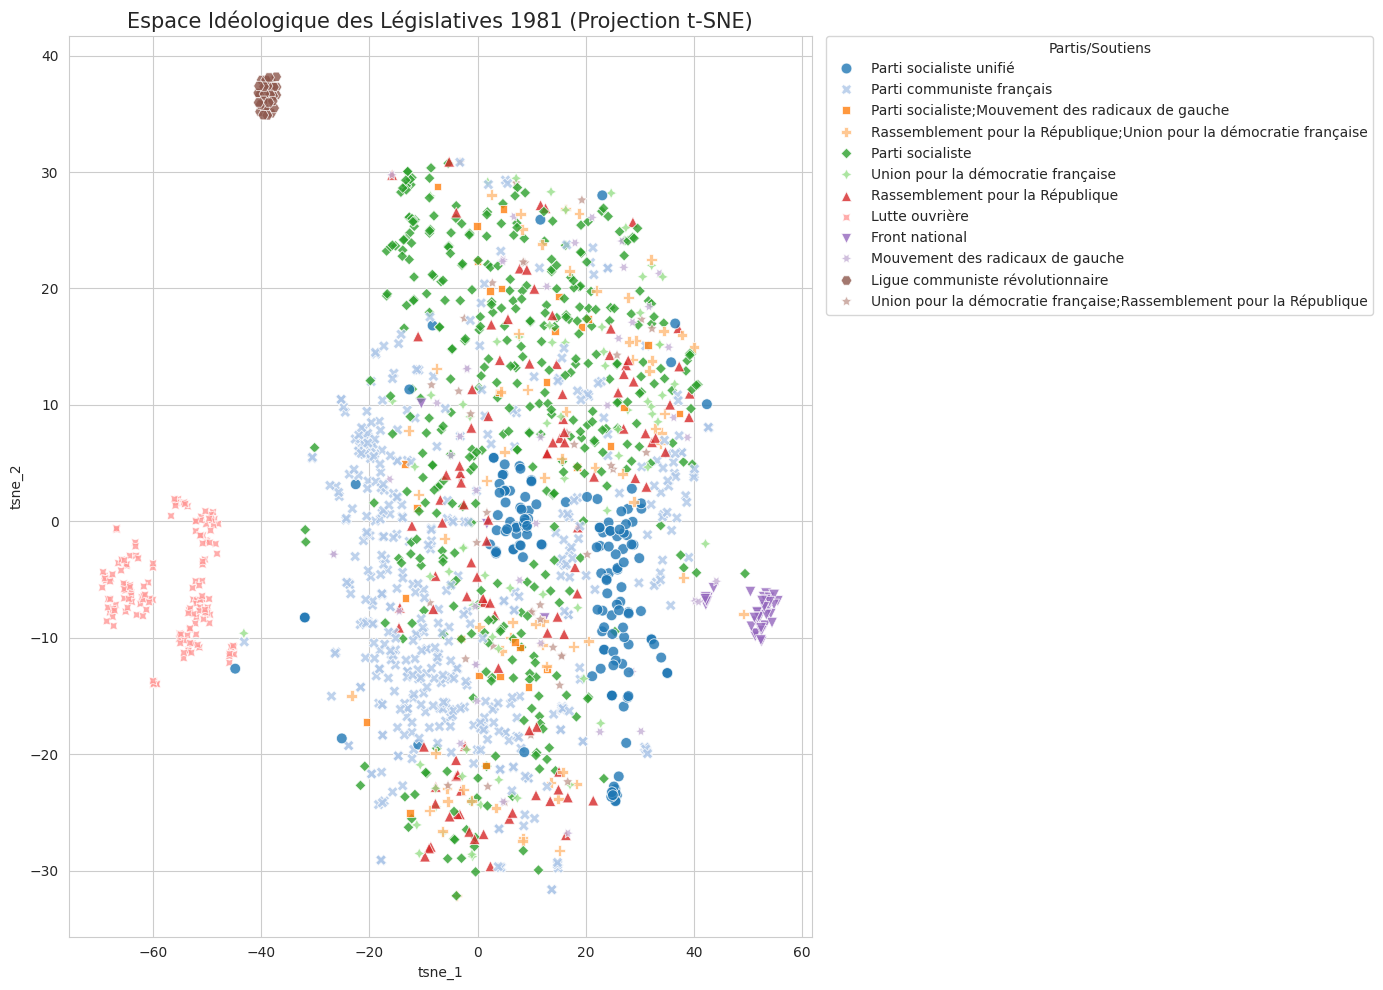

In [28]:
# 1. Définir un dictionnaire de couleurs (à adapter selon tes noms de partis exacts)
custom_palette = {
    'PS': '#E400D0',        # Rose
    'RPR': '#0055A4',       # Bleu soutenu
    'UDF': '#00BFFF',       # Bleu clair
    'PCF': '#FF0000',       # Rouge
    'Ecologiste': '#00FF00', # Vert
    'FN': '#000033',        # Bleu nuit
    # Ajoute les autres ou laisse Seaborn gérer le reste
}

# 2. Améliorer le rendu visuel
plt.figure(figsize=(14, 10))
sns.set_style("whitegrid") # Fond propre pour mieux voir les points

plot = sns.scatterplot(
    data=df_final, 
    x='tsne_1', 
    y='tsne_2', 
    hue='titulaire-soutien', 
    palette='tab20',      # 'tab20' offre plus de distinction que 'viridis'
    style='titulaire-soutien', # Change aussi la forme du point pour aider la lecture
    alpha=0.8, 
    edgecolor='w', 
    s=60                  # Taille des points augmentée
)

plt.title("Espace Idéologique des Législatives 1981 (Projection t-SNE)", fontsize=15)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title="Partis/Soutiens")
plt.tight_layout()
plt.show()

On voit que la prédiction est mauvaise. + ajout petite phrase intro

. Les pôles idéologiques isolés (Les "Outliers" par nature)
Certains groupes sont très loin du nuage central. Cela signifie que leur vocabulaire et leurs thématiques sont radicalement différents du reste de la classe politique :

Ligue Communiste Révolutionnaire (Brun, en haut à gauche) : Ils forment un bloc extrêmement compact et isolé. Leur langage est très spécifique (trotskisme), ce qui les rend "uniques" pour CamemBERT.

Lutte Ouvrière (Rose, à gauche) : On observe deux petits sous-groupes. Comme la LCR, leur lexique est très homogène, ce qui crée ce cluster bien séparé des partis de gouvernement.

Front National (Violet, à droite) : En 1981, le FN est encore marginal. Sa position isolée à droite montre que ses thématiques (immigration, sécurité) ne sont pas encore partagées ou formulées de la même manière par la droite classique (RPR/UDF).

2. Le "Cœur de la mêlée" : La bataille pour le centre
Le grand nuage central est là où se joue l'élection. C'est ici que l'interprétation devient subtile :

Le chevauchement PS (Vert) / RPR (Rouge) / UDF (Vert clair) : On remarque que ces points sont très mélangés au centre.

Interprétation : En 1981, même si les idées s'opposent, le format des manifestes et le socle républicain (institutions, gestion locale, économie) utilisent un vocabulaire commun.

Le t-SNE montre que la frontière sémantique entre un "gaulliste social" et un "socialiste modéré" est parfois poreuse.

Le Parti Communiste Français (Bleu clair, croix) : Il est très étalé. On le retrouve beaucoup sur la gauche du nuage central, mais il s'étend aussi vers le bas. Cela reflète la double identité du PCF en 1981 : un discours très idéologique national et des ancrages très locaux.

3. La distance au centre (L'homogénéité du discours)
Les groupes compacts : Regardez les petits cercles bleus foncés (Parti Socialiste Unifié). Ils sont assez proches les uns des autres, ce qui suggère un "prêt-à-penser" ou une ligne éditoriale très stricte pour leurs manifestes.

La dispersion du RPR et de l'UDF : Leurs points (triangles rouges et losanges verts clairs) sont partout. Cela montre une grande variété de discours, probablement parce que les candidats locaux adaptaient énormément leur texte à leur circonscription.

In [38]:
# Créer une colonne simplifiée pour la lisibilité
def regrouper_partis(label):
    if 'socialiste' in label.lower() or 'radicaux de gauche' in label.lower():
        return 'Bloc de Gauche'
    if 'République' in label or 'démocratie française' in label:
        return 'Bloc de Droite'
    if 'communiste' in label.lower() and 'révolutionnaire' not in label.lower():
        return 'PCF'
    if 'Lutte ouvrière' in label or 'Ligue communiste' in label:
        return 'Extrême Gauche'
    return 'Autres'

df_final['bloc_politique'] = df_final['titulaire-soutien'].apply(regrouper_partis)

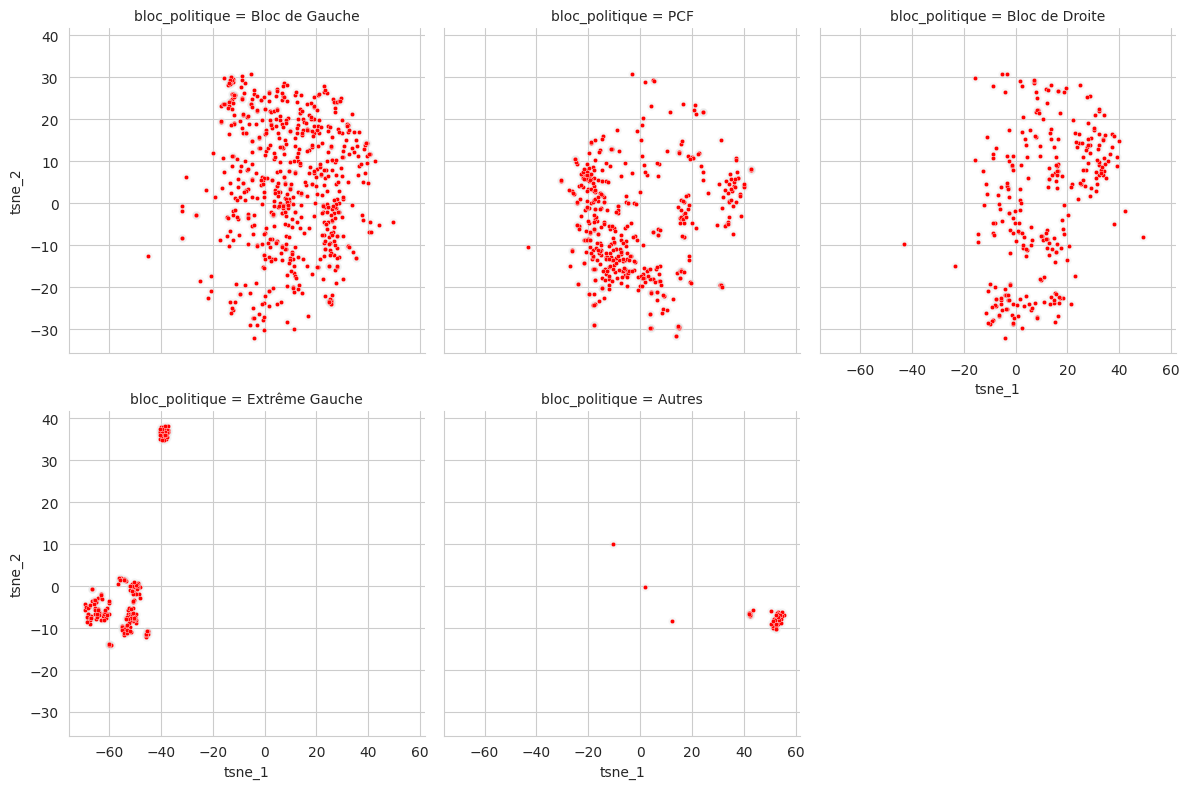

In [ ]:
#On isole les points chauds Cela permet de voir immédiatement si le "Bloc de Gauche" occupe un espace cohérent ou s'il est dispersé.
g = sns.FacetGrid(df_final, col="bloc_politique", col_wrap=3, height=4)
# On trace tous les points en gris en fond
g.map(sns.scatterplot, "tsne_1", "tsne_2", color="lightgrey", alpha=0.2)
# On surligne les points du parti spécifique en couleur
g.map(sns.scatterplot, "tsne_1", "tsne_2", color="red", s=10)